## **Healthcare Insurance Claim Fraud Detection & Analysis**

**Goal:**
<br>
The goal of this project is to perform data exploration and analysis on healthcare claims, and develop predictive machine learning models to detect potential fraud.

**Dataset:**
<br>
Health insurance claims (20,000 records, 30 features, ~1,000 hospital entities) from Kaggle.

**Plan of Action:**
1.   **Exploratory Data Analysis** (distribution, anomalies, missing value, statistics, etc.)
2.   **Feature Engineering** (Drop features, transform date feature for time series models)
3.   **Data Pre-processing** (one-hot encoding, label encoding, standardization, scaling, spliting)
4.   **Model Selection & Training** (random forest, XGBoost, ARIMA.)
5.   **Model Evaluation** (using cross-validation, AU-ROC, precision/recall, F1-score)
6.   **Hyperparameter Tuning** (Grid Search and Cross-validation)
7.   **Feature Importance Analysis** (identify key drivers of fraudulent claims)

8.   **Insights & Visualization**




In [63]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import chi2_contingency
import plotly.express as px
from sklearn.feature_selection import mutual_info_classif
import matplotlib.dates as mdates
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, mean_absolute_error, make_scorer
import xgboost as xgb
import statsmodels.api as sm
from sklearn.inspection import PartialDependenceDisplay
import shap


In [64]:
# Upload CSV file
uploaded = files.upload()
df = pd.read_csv('synthetic_health_claims.csv')

Saving synthetic_health_claims.csv to synthetic_health_claims (4).csv


## 1.  Exploratory Data Analysis (distribution, anomalies, missing value, statistics, etc.)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20100 entries, 0 to 20099
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Patient_ID                          20100 non-null  int64  
 1   Policy_Number                       20100 non-null  object 
 2   Claim_ID                            20100 non-null  int64  
 3   Claim_Date                          20100 non-null  object 
 4   Service_Date                        20100 non-null  object 
 5   Policy_Expiration_Date              20100 non-null  object 
 6   Claim_Amount                        20100 non-null  float64
 7   Patient_Age                         20100 non-null  int64  
 8   Patient_Gender                      20100 non-null  object 
 9   Patient_City                        20100 non-null  object 
 10  Patient_State                       20100 non-null  object 
 11  Hospital_ID                         20100

In [66]:
df.shape

(20100, 30)

In [67]:
df.head(2)

,Patient_ID,Policy_Number,Claim_ID,Claim_Date,Service_Date,Policy_Expiration_Date,Claim_Amount,Patient_Age,Patient_Gender,Patient_City,...,Discharge_Type,Length_of_Stay_Days,Service_Type,Deductible_Amount,CoPay_Amount,Number_of_Previous_Claims_Patient,Number_of_Previous_Claims_Provider,Provider_Patient_Distance_Miles,Claim_Submitted_Late,Is_Fraudulent
0,67349080,XAI956194550,18874,2021-06-16,2021-05-01,2024-11-20,462337.48,28,Female,Houston,...,Rehab/Skilled Nursing,47,Inpatient,3440.06,824.59,0,16,939.08,True,False
1,85973291,XAI215993963,8762,2025-01-19,2025-01-17,2029-04-07,1883481.30,40,Other,Washington,...,Deceased,0,Outpatient,3618.40,851.43,0,6,170.40,False,True


1. Handle Missing Values.

In [68]:
missing_counts = df.isnull().sum()

2. Statistics Summary

In [69]:
# Numerical features
num_features = df.select_dtypes(include=['int64', 'float64']).columns
print("Number of numerical features:", len(num_features))
print("Numerical features:", list(num_features))

# Categorical features
cat_features = df.select_dtypes(include=['object', 'category']).columns
print("\nNumber of categorical features:", len(cat_features))
print("Categorical features:", list(cat_features))

Number of numerical features: 13
Numerical features: ['Patient_ID', 'Claim_ID', 'Claim_Amount', 'Patient_Age', 'Hospital_ID', 'Procedure_Code', 'Number_of_Procedures', 'Length_of_Stay_Days', 'Deductible_Amount', 'CoPay_Amount', 'Number_of_Previous_Claims_Patient', 'Number_of_Previous_Claims_Provider', 'Provider_Patient_Distance_Miles']

Number of categorical features: 15
Categorical features: ['Policy_Number', 'Claim_Date', 'Service_Date', 'Policy_Expiration_Date', 'Patient_Gender', 'Patient_City', 'Patient_State', 'Provider_Type', 'Provider_Specialty', 'Provider_City', 'Provider_State', 'Diagnosis_Code', 'Admission_Type', 'Discharge_Type', 'Service_Type']


In [70]:
# Columns to exclude
exclude_cols = ['Patient_ID', 'Claim_ID', 'Hospital_ID', 'Procedure_Code']

# Select numerical features excluding the ones above
numerical_cols = [col for col in num_features if col not in exclude_cols]

# Summary statistics
df[numerical_cols].describe().astype(int)

,Claim_Amount,Patient_Age,Number_of_Procedures,Length_of_Stay_Days,Deductible_Amount,CoPay_Amount,Number_of_Previous_Claims_Patient,Number_of_Previous_Claims_Provider,Provider_Patient_Distance_Miles
count,20100,20100,20100,20100,20100,20100,20100,20100,20100
mean,1245349,45,5,4,2508,499,0,10,499
std,698300,26,2,13,1443,288,0,6,289
min,5516,0,1,0,0,0,0,0,0
25%,667410,22,3,0,1251,248,0,5,246
50%,1221706,45,6,0,2508,499,0,10,498
75%,1835603,68,8,0,3755,750,0,15,751
max,2499688,90,10,60,4999,999,1,34,999


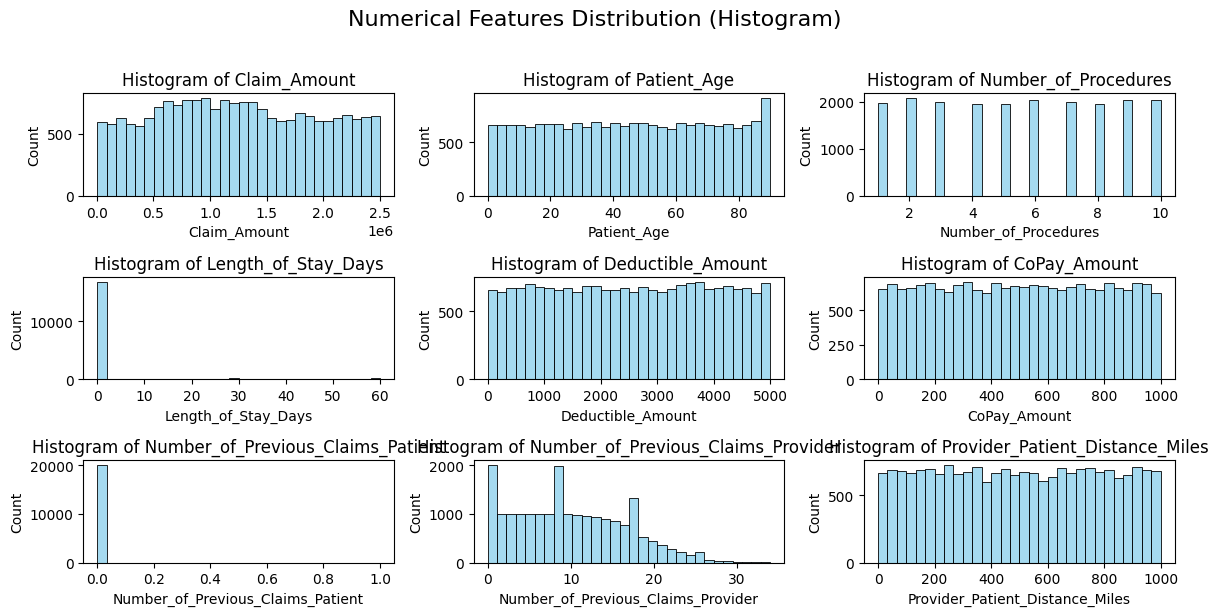

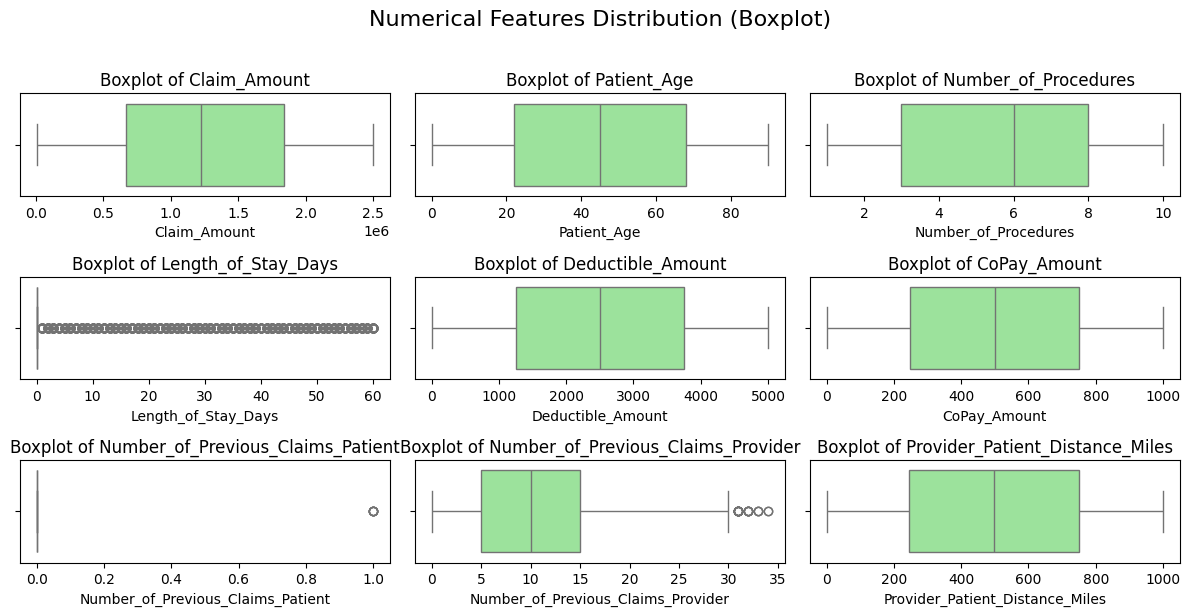

In [71]:
# Histograms
plt.figure(figsize=[12, 2 * math.ceil(len(numerical_cols)/3)])
plt.suptitle('Numerical Features Distribution (Histogram)', fontsize=16, y=1.02)
for c in range(len(numerical_cols)):
    plt.subplot(math.ceil(len(numerical_cols)/3), 3, c+1)
    sns.histplot(df[numerical_cols[c]], kde=False, bins=30, color='skyblue')
    plt.title(f'Histogram of {numerical_cols[c]}')
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=[12, 2 * math.ceil(len(numerical_cols)/3)])
plt.suptitle('Numerical Features Distribution (Boxplot)', fontsize=16, y=1.02)
for c in range(len(numerical_cols)):
    plt.subplot(math.ceil(len(numerical_cols)/3), 3, c+1)
    sns.boxplot(x=df[numerical_cols[c]], color='lightgreen')
    plt.title(f'Boxplot of {numerical_cols[c]}')
plt.tight_layout()
plt.show()

In [72]:
# Columns to exclude
exclude_cols = ['Policy_Number', 'Claim_Date', 'Service_Date', 'Policy_Expiration_Date']

# Select categorical features excluding the ones above
categorical_cols = [col for col in cat_features if col not in exclude_cols]

# Summary statistics
df[categorical_cols].describe()

,Patient_Gender,Patient_City,Patient_State,Provider_Type,Provider_Specialty,Provider_City,Provider_State,Diagnosis_Code,Admission_Type,Discharge_Type,Service_Type
count,20100,20100,20100,20100,20100,20100,20100,20100,20100,20100,20100
unique,3,20,20,6,10,20,20,20,5,5,6
top,Female,San Antonio,NY,Specialist Office,Cardiology,Denver,PA,J02.9,Elective,Rehab/Skilled Nursing,Pharmacy
freq,6723,1069,1055,5084,2797,1041,1057,1289,4452,4071,3398


In [73]:
for col in categorical_cols:
    print(df[col].value_counts(normalize=True) * 100)

Patient_Gender
Female    33.447761
Other     33.373134
Male      33.179104
Name: proportion, dtype: float64
Patient_City
San Antonio      5.318408
San Diego        5.303483
Denver           5.253731
Charlotte        5.208955
Dallas           5.174129
Chicago          5.079602
Austin           5.054726
Jacksonville     5.029851
San Jose         5.019900
Seattle          5.019900
Fort Worth       4.965174
Columbus         4.920398
Los Angeles      4.910448
Indianapolis     4.900498
Philadelphia     4.895522
Washington       4.875622
New York         4.855721
San Francisco    4.805970
Phoenix          4.746269
Houston          4.661692
Name: proportion, dtype: float64
Patient_State
NY    5.248756
MN    5.114428
TX    5.104478
PA    5.094527
DC    5.089552
MA    5.084577
WI    5.079602
MI    5.059701
AZ    5.059701
IN    5.004975
FL    4.985075
MD    4.985075
NC    4.970149
WA    4.940299
CO    4.905473
VA    4.900498
IL    4.900498
GA    4.895522
OH    4.880597
CA    4.696517
Name: propor

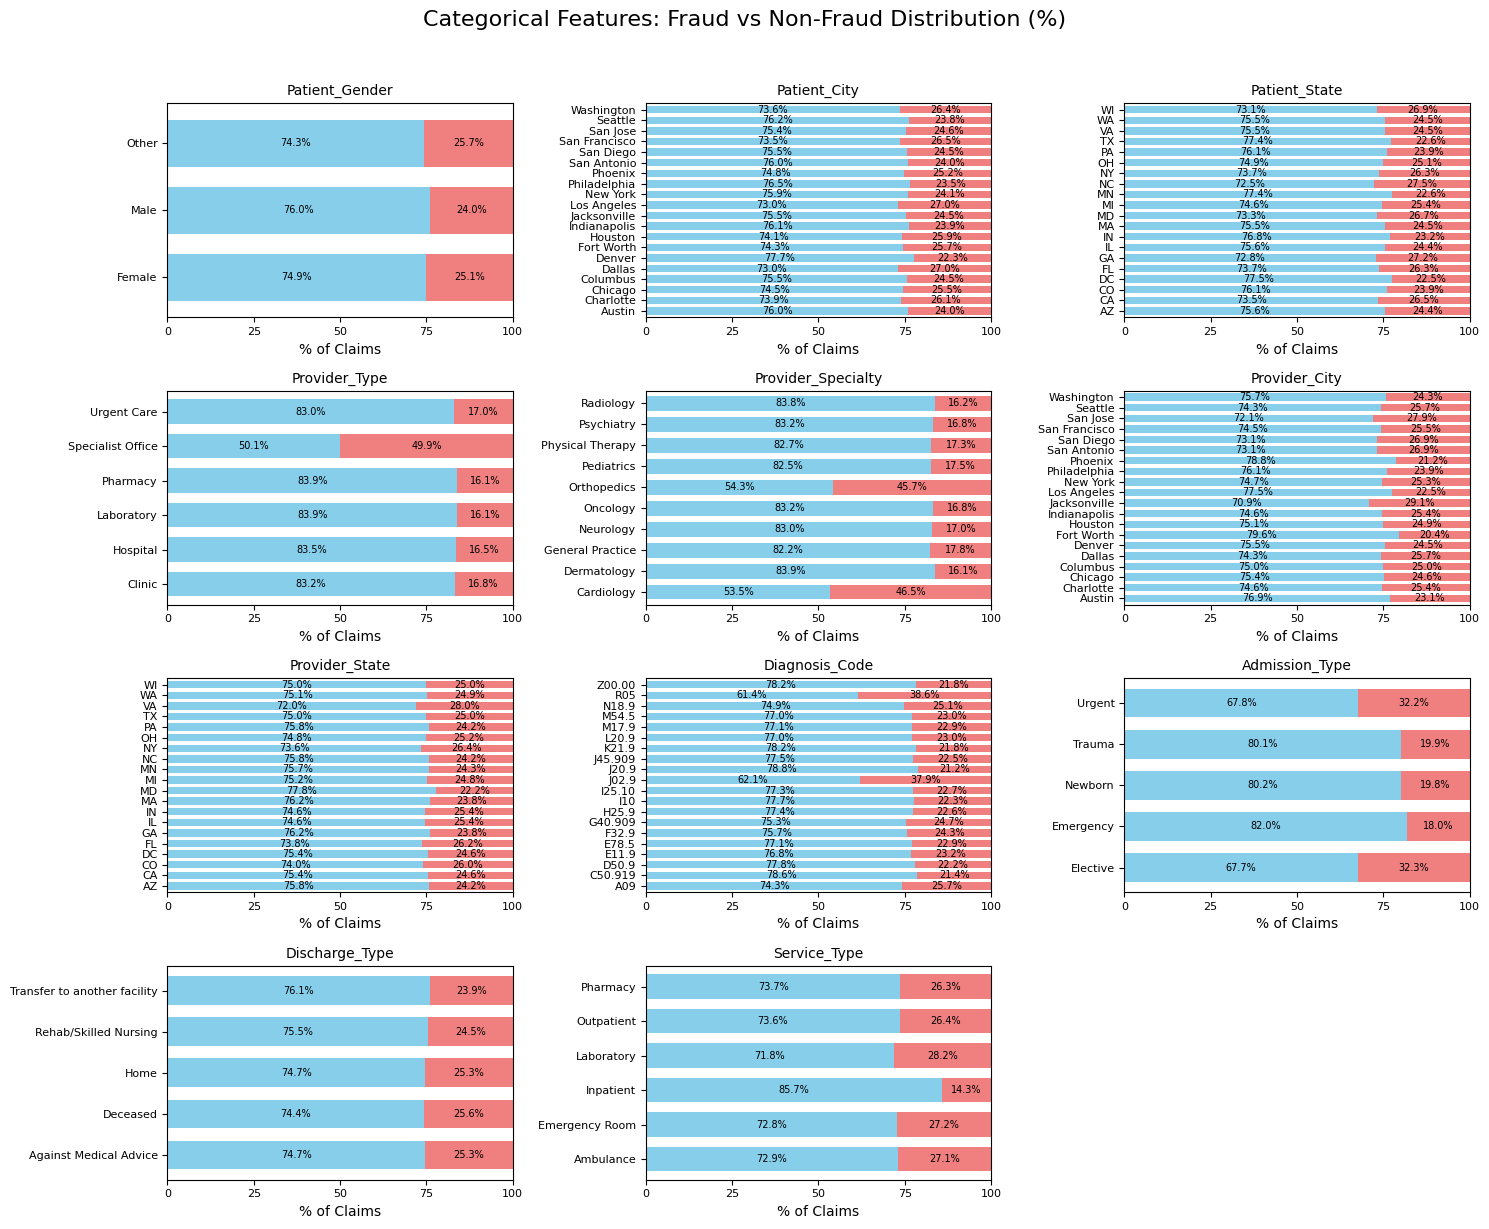

In [74]:
plt.figure(figsize=[15, 3*math.ceil(len(categorical_cols)/3)])

for i, col in enumerate(categorical_cols):
    plt.subplot(math.ceil(len(categorical_cols)/3), 3, i+1)

    # Cross-tab for fraud vs non-fraud
    cross_tab = pd.crosstab(df[col], df['Is_Fraudulent'], normalize='index') * 100
    cross_tab = cross_tab.reset_index()

    # Plot stacked bars (Fraud vs Non-Fraud %)
    ax = cross_tab.set_index(col).plot(
        kind='barh',
        stacked=True,
        color=['skyblue', 'lightcoral'],
        ax=plt.gca(),
        width=0.7,
        legend=False
    )

    plt.title(col, fontsize=10)
    plt.xlabel('% of Claims')
    plt.ylabel('')
    plt.xlim(0, 100)
    plt.xticks([0, 25, 50, 75, 100], fontsize=8)
    plt.yticks(fontsize=8)

    # Annotate percentages
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=7, color='black')

plt.suptitle('Categorical Features: Fraud vs Non-Fraud Distribution (%)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Observations from categorical features plots above:
1. Provider Specialty: **Orthopedics and Cardiology** show substantially higher fraud rates (>45%) All other specialties keep about 17%.
2. Provider Type: **Specialist Office** stands out with a fraud rate above 49%. Other provider types hover around a 17% fraud rate.
3. Admission Type: **Urgent and Elective** admissions have elevated fraud rates (~32%). All other admission types remain below 20%.
4. Diagnosis Code: **R05 (Cough) and J02 (Acute Pharyngitis)** rank the highest, each with fraud rates exceeding 37%. Other diagnosis codes show comparatively lower fraud activity.

3. Chi-square test: statistical test to check if the categorical feature is significantly associated with the target.

In [75]:
for col in categorical_cols:
    table = pd.crosstab(df[col], df['Is_Fraudulent'])
    chi2, p, dof, ex = chi2_contingency(table)
    print(f"{col}: p-value={p:.4f}")

Patient_Gender: p-value=0.0666
Patient_City: p-value=0.6189
Patient_State: p-value=0.1177
Provider_Type: p-value=0.0000
Provider_Specialty: p-value=0.0000
Provider_City: p-value=0.0012
Provider_State: p-value=0.7547
Diagnosis_Code: p-value=0.0000
Admission_Type: p-value=0.0000
Discharge_Type: p-value=0.3984
Service_Type: p-value=0.0000


Chi-square test results indicate that fraud is unevenly distributed. Provider features (Type, Specialty) and medical features (Diagnosis, Admission) show strong associations with fraud, consistent with the plot observations.

4. Correlation heatmap of numerical features.

In [76]:
df['Is_Fraudulent'] = df['Is_Fraudulent'].astype(int)

In [77]:
numerical_cols.append('Is_Fraudulent')

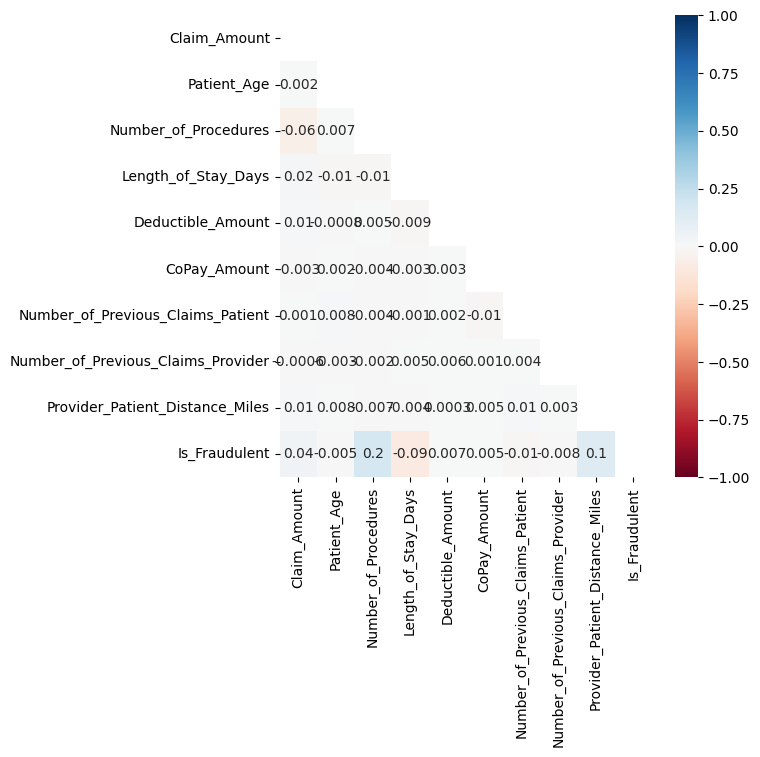

In [78]:
matrix = np.triu(df[numerical_cols].corr())
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, ax=ax, fmt='.1g', vmin=-1, vmax=1, center= 0, mask=matrix, cmap='RdBu')
plt.show()

The correlations among numerical features are very weak, likely because their relationships with the target are nonlinear and not captured by Pearson correlation.

5. Data over time `Claim_Date`.

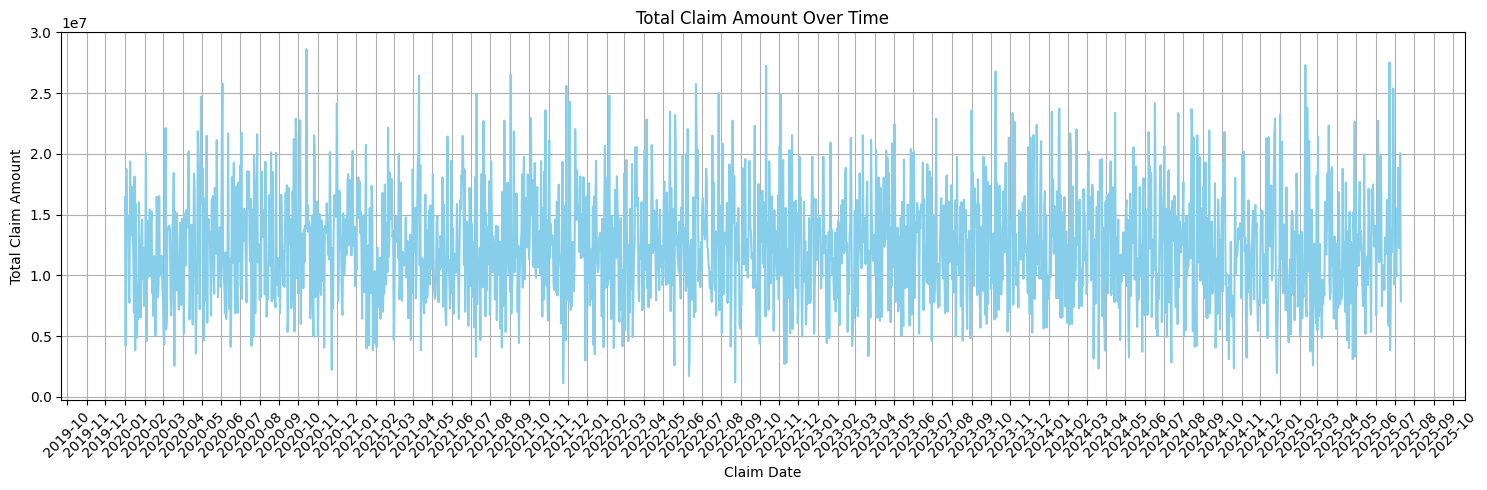

In [79]:
# Ensure Claim_Date is datetime type
df['Claim_Date'] = pd.to_datetime(df['Claim_Date'])

# Aggregate claim amount per day
daily_claims = df.groupby('Claim_Date')['Claim_Amount'].sum()

# Plot
plt.figure(figsize=(15,5))
plt.plot(daily_claims.index, daily_claims.values, color='skyblue')
plt.xlabel('Claim Date')
plt.ylabel('Total Claim Amount')
plt.title('Total Claim Amount Over Time')
plt.grid(True)

# Format x-axis dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # major ticks per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # format as YYYY-MM
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

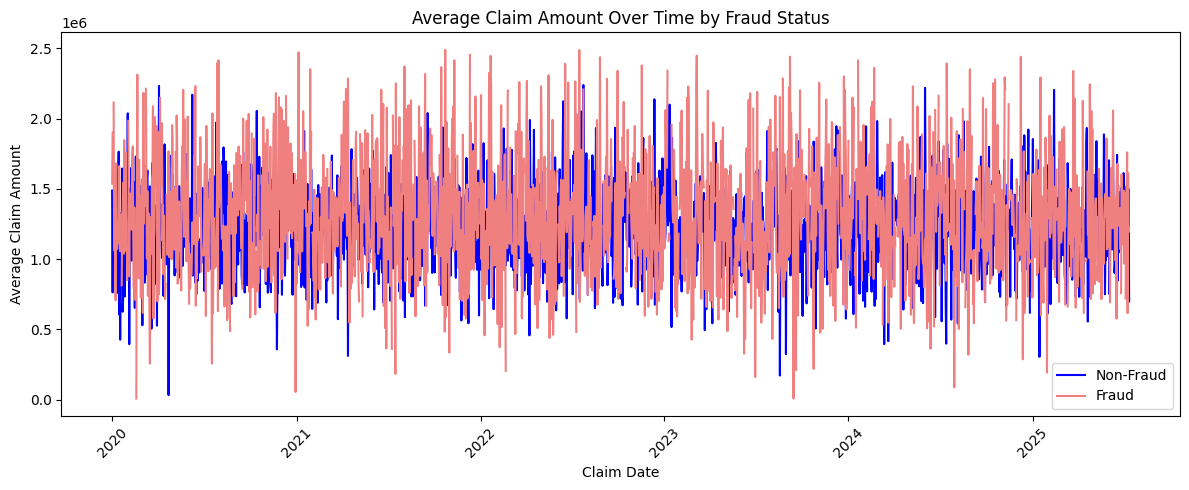

In [80]:
# Group by date and fraud status, compute average claim amount
daily_avg = df.groupby(['Claim_Date', 'Is_Fraudulent'])['Claim_Amount'].mean().reset_index()

# Pivot for plotting
daily_avg_pivot = daily_avg.pivot(index='Claim_Date', columns='Is_Fraudulent', values='Claim_Amount')

# Plot
plt.figure(figsize=(12,5))
plt.plot(daily_avg_pivot.index, daily_avg_pivot[0], label='Non-Fraud', color='blue')
plt.plot(daily_avg_pivot.index, daily_avg_pivot[1], label='Fraud', color='lightcoral')
plt.xlabel('Claim Date')
plt.ylabel('Average Claim Amount')
plt.title('Average Claim Amount Over Time by Fraud Status')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

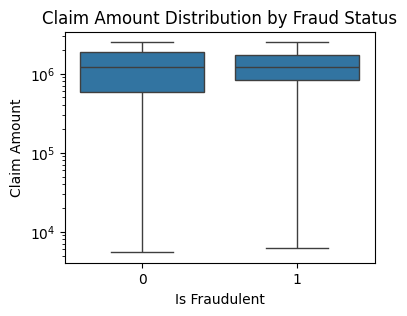

In [81]:
plt.figure(figsize=(4,3))
sns.boxplot(x='Is_Fraudulent', y='Claim_Amount', data=df)
plt.yscale('log')  # optional, if claim amounts vary widely
plt.xlabel('Is Fraudulent')
plt.ylabel('Claim Amount')
plt.title('Claim Amount Distribution by Fraud Status')
plt.show()

# 3. Feature Engineering

   1. Fix `gender` feature:

In [82]:
# Observe values of 'Patient_Gender' with counts and percentages
gender_dist = df['Patient_Gender'].value_counts(dropna=False)
gender_percent = df['Patient_Gender'].value_counts(normalize=True, dropna=False) * 100

gender_summary = pd.DataFrame({
    'Count': gender_dist,
    'Percentage': gender_percent.round(2)
})

print(gender_summary)

                Count  Percentage
Patient_Gender                   
Female           6723       33.45
Other            6708       33.37
Male             6669       33.18


Since about 33% of `Patient_Gender` is labeled as 'Other', which is too large to drop, I decided to reclassify it as 'gender_unknown', while grouping Male and Female under 'gender_known'.

In [83]:
# Map gender into two groups: known vs unknown
df['gender'] = df['Patient_Gender'].map(
    lambda x: 'gender_unknown' if x == 'Other' else 'gender_known'
)

# Check distribution with percentages
print(df['gender'].value_counts(normalize=True) * 100)

gender
gender_known      66.626866
gender_unknown    33.373134
Name: proportion, dtype: float64


In [84]:
df = df.drop('Patient_Gender', axis=1)

2. Drop columns: `Patient_ID`, `Policy_Number`, `Claim_ID` because they are unique identifiers and do not carry predictive signal for fraud; they can lead to overfitting.



Claim_Date, Service_Date, Policy_Expiration_Date.

In [85]:
# Drop columns that are unique identifiers
df = df.drop(['Patient_ID', 'Policy_Number', 'Claim_ID'], axis=1)

Drop `Patient_City`, `Patient_State`, `Provider_State` and `Provider_City`  because the distribution are very even (i.e., no city/state has a dominant share or clear pattern related to fraud), it likely doesn’t add predictive power.

In [86]:
df = df.drop(['Patient_City'], axis=1)

In [87]:
df = df.drop(['Patient_State', 'Provider_City', 'Provider_State'], axis=1)

3. Transform boolean feature `Claim_Submitted_Late`.

In [88]:
df['Claim_Submitted_Late'] = df['Claim_Submitted_Late'].astype(int)

   4. Handle 3 Date features: `Claim_Date`, `Service_Date`, `Policy_Expiration_Date`

`Claim_Date`: I will use it as main time index for time series modeling of fraud detection or claim prediction. Transformed it from obj to datetime obj.

In [89]:
(df['Claim_Date'].dtype == 'datetime64[ns]')

True

`Service_Date`: used it to engineer new feature:
  *   `claim_lag = (Claim_Date - Service_Date).days`

In [90]:
df['Service_Date'] = pd.to_datetime(df['Service_Date'])
df['claim_lag'] = (df['Claim_Date'] - df['Service_Date']).dt.days
df = df.drop(['Service_Date'], axis=1)

`Policy_Expiration_Date`: used it to engineer new feature:
*   `days_until_policy_expiry = (Policy_Expiration_Date - Claim_Date).days`



In [91]:
df['Policy_Expiration_Date'] = pd.to_datetime(df['Policy_Expiration_Date'])
df['days_until_policy_expiry'] = (df['Policy_Expiration_Date'] - df['Claim_Date']).dt.days
df = df.drop(['Policy_Expiration_Date'], axis=1)

# 3. Data Pre-processing (one-hot encoding, label encoding, standardization, scaling, spliting etc.)

1. Applied one-hot encoding for features: `Provider_Type`, `Procedure_Code`, `Provider_Specialty`, `Diagnosis_Code`, `Admission_Type`, `Discharge_Type`, `Service_Type`, `gender`.

In [92]:
# Select categorical columns
onehot_cols = [
    'Provider_Type',
    'Provider_Specialty',
    'Diagnosis_Code',
    'Admission_Type',
    'Procedure_Code',
    'Discharge_Type',
    'Service_Type',
    'gender'
]

# Initialize encoder
encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown="ignore")

# Fit and transform
encoded_array = encoder.fit_transform(df[onehot_cols])

# Convert back to DataFrame with column names
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(onehot_cols))

# Concatenate with original df (dropping original categorical cols)
df_encoded = pd.concat([df.drop(columns=onehot_cols).reset_index(drop=True),
                        encoded_df.reset_index(drop=True)], axis=1)

print("Shape before encoding:", df.shape)
print("Shape after encoding:", df_encoded.shape)
df_encoded.head()

Shape before encoding: (20100, 23)
Shape after encoding: (20100, 89)


,Claim_Date,Claim_Amount,Patient_Age,Hospital_ID,Number_of_Procedures,Length_of_Stay_Days,Deductible_Amount,CoPay_Amount,Number_of_Previous_Claims_Patient,Number_of_Previous_Claims_Provider,...,Discharge_Type_Rehab/Skilled Nursing,Discharge_Type_Transfer to another facility,Service_Type_Ambulance,Service_Type_Emergency Room,Service_Type_Inpatient,Service_Type_Laboratory,Service_Type_Outpatient,Service_Type_Pharmacy,gender_gender_known,gender_gender_unknown
0,2021-06-16,462337.48,28,53,2,47,3440.06,824.59,0,16,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2025-01-19,1883481.30,40,408,2,0,3618.40,851.43,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2023-05-05,1500658.89,90,106,1,0,2442.41,616.23,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,2021-11-07,572237.61,49,933,4,0,587.78,459.33,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2024-03-25,2088293.84,24,827,5,0,3047.55,847.40,0,15,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


2. **Split Data** : 70% for train data, 15% for validation data and 15% for test data. Performed 2 types of splits:
*   Classification Models Split (Random Forest and XGBoost)
*   Time Series Model Split (ARIMA)

In [93]:
X = df_encoded.drop(columns=['Is_Fraudulent'])
y = df_encoded['Is_Fraudulent']

# Classification Models Split

# Step 1: Split 70% train, 30% temp (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step 2: Split temp into 50% validation, 50% test → gives 15% each
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Classification train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")

# Time Series Models Split
# Ensure sorted by date
df_ts = df_encoded.sort_values('Claim_Date')

n_total = len(df_ts)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.15)

train_ts = df_ts.iloc[:n_train]
val_ts = df_ts.iloc[n_train:n_train+n_val]
test_ts = df_ts.iloc[n_train+n_val:]
ts_target = df['Is_Fraudulent']

print(f"Time series train: {train_ts.shape}, val: {val_ts.shape}, test: {test_ts.shape}")

Classification train: (14070, 88), val: (3015, 88), test: (3015, 88)
Time series train: (14070, 89), val: (3015, 89), test: (3015, 89)


In [94]:
# Drop date for classifical model
X_train = X_train.drop(columns=['Claim_Date'])
X_val = X_val.drop(columns=['Claim_Date'])
X_test = X_test.drop(columns=['Claim_Date'])

In [95]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)

3. Feature Scaling.

Since my data exhibits very weak linear correlations, I will skip linear models like Logistic Regression and SVM, and therefore omit feature scaling, as Random Forest, XGBoost, and ARIMA do not require it.

#4.   **Model Selection & Training**


*   Random Forest
*   XGBoost
*   Time series: ARIMA



In [96]:
# -------------------------------
# Random Forest
# -------------------------------

# Initialize and train
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on validation
rf_val_pred = rf_model.predict(X_val)
rf_val_prob = rf_model.predict_proba(X_val)[:,1]

# Evaluate
print("Random Forest Validation Metrics:")
print(classification_report(y_val, rf_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, rf_val_prob))

# -------------------------------
# XGBoost
# -------------------------------

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Predict on validation
xgb_val_pred = xgb_model.predict(X_val)
xgb_val_prob = xgb_model.predict_proba(X_val)[:,1]

# Evaluate
print("XGBoost Validation Metrics:")
print(classification_report(y_val, xgb_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, xgb_val_prob))

# -------------------------------
# ARIMA (Time Series)
# -------------------------------

# Suppose ts_target is your time series data (Claim_Amount over time)
# Split into train and test
train_size = int(len(ts_target) * 0.7)
ts_train, ts_test = ts_target[:train_size], ts_target[train_size:]

# Fit ARIMA model (example p,d,q = 5,1,0)
arima_model = sm.tsa.ARIMA(ts_train, order=(5,1,0))
arima_result = arima_model.fit()

# Forecast
forecast = arima_result.forecast(steps=len(ts_test))

# Evaluate
mse = mean_squared_error(ts_test, forecast)
print(f"ARIMA Test MSE: {mse:.2f}")

Random Forest Validation Metrics:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2263
           1       0.95      0.52      0.67       752

    accuracy                           0.87      3015
   macro avg       0.91      0.75      0.80      3015
weighted avg       0.88      0.87      0.86      3015

ROC-AUC: 0.8702382099641786


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:30:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation Metrics:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2263
           1       0.85      0.58      0.69       752

    accuracy                           0.87      3015
   macro avg       0.86      0.77      0.80      3015
weighted avg       0.87      0.87      0.86      3015

ROC-AUC: 0.8700293105555608
ARIMA Test MSE: 0.25


# 5. Model Evaluation (using cross-validation, AU-ROC, precision/recall, F1-score)

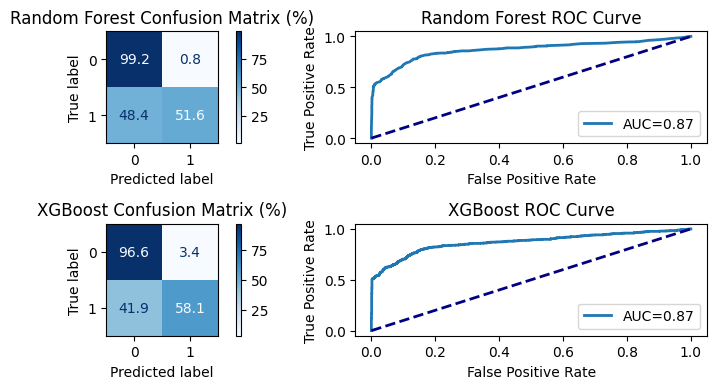

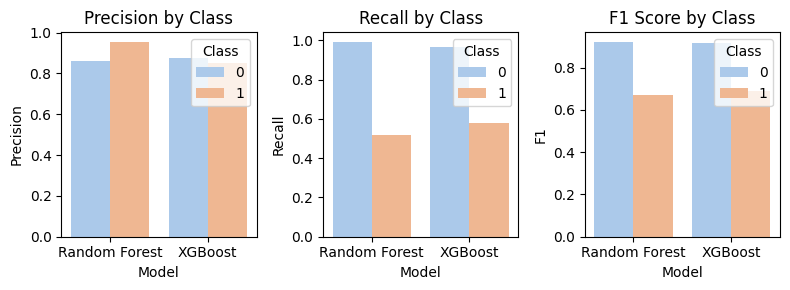

In [97]:
# -------------------------------
# Model dictionary
# -------------------------------
models = {
    "Random Forest": {"y_true": y_val, "y_pred": rf_val_pred, "y_score": rf_val_prob},
    "XGBoost": {"y_true": y_val, "y_pred": xgb_val_pred, "y_score": xgb_val_prob}
}

# -------------------------------
# Confusion Matrix and ROC Curve
# -------------------------------
fig, axes = plt.subplots(len(models), 2, figsize=(8, 2*len(models)))

for i, (name, vals) in enumerate(models.items()):
    # Confusion Matrix (%)
    cm = confusion_matrix(vals["y_true"], vals["y_pred"])
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=[0,1])
    disp.plot(cmap='Blues', ax=axes[i,0], values_format='.1f')
    axes[i,0].set_title(f'{name} Confusion Matrix (%)')

    # ROC Curve
    fpr, tpr, _ = roc_curve(vals["y_true"], vals["y_score"])
    roc_auc = auc(fpr, tpr)
    axes[i,1].plot(fpr, tpr, lw=2, label=f'AUC={roc_auc:.2f}')
    axes[i,1].plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    axes[i,1].set_xlabel('False Positive Rate')
    axes[i,1].set_ylabel('True Positive Rate')
    axes[i,1].set_title(f'{name} ROC Curve')
    axes[i,1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# -------------------------------
# Precision, Recall, F1 Bar Plot
# -------------------------------
import pandas as pd

prf_data = []
for name, vals in models.items():
    for cls in [0,1]:
        prf_data.append({
            "Model": name,
            "Class": cls,
            "Precision": precision_score(vals["y_true"], vals["y_pred"], pos_label=cls),
            "Recall": recall_score(vals["y_true"], vals["y_pred"], pos_label=cls),
            "F1": f1_score(vals["y_true"], vals["y_pred"], pos_label=cls)
        })
prf_df = pd.DataFrame(prf_data)

fig, axes = plt.subplots(1,3, figsize=(8,3))
sns.barplot(data=prf_df, x="Model", y="Precision", hue="Class", ax=axes[0], palette="pastel")
sns.barplot(data=prf_df, x="Model", y="Recall", hue="Class", ax=axes[1], palette="pastel")
sns.barplot(data=prf_df, x="Model", y="F1", hue="Class", ax=axes[2], palette="pastel")
axes[0].set_title("Precision by Class")
axes[1].set_title("Recall by Class")
axes[2].set_title("F1 Score by Class")
plt.tight_layout()
plt.show()

# -------------------------------
# ARIMA Forecast Plot
# -------------------------------


In [98]:
# -----------------------------
# Random Forest metrics
# -----------------------------
rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_val, rf_val_pred),
    'Precision': precision_score(y_val, rf_val_pred),
    'Recall': recall_score(y_val, rf_val_pred),
    'F1 Score': f1_score(y_val, rf_val_pred),
    'ROC-AUC': roc_auc_score(y_val, rf_val_prob),
    'MSE': np.nan,
    'RMSE': np.nan,
    'MAE': np.nan,
    'MAPE': np.nan
}

# -----------------------------
# XGBoost metrics
# -----------------------------
xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_val, xgb_val_pred),
    'Precision': precision_score(y_val, xgb_val_pred),
    'Recall': recall_score(y_val, xgb_val_pred),
    'F1 Score': f1_score(y_val, xgb_val_pred),
    'ROC-AUC': roc_auc_score(y_val, xgb_val_prob),
    'MSE': np.nan,
    'RMSE': np.nan,
    'MAE': np.nan,
    'MAPE': np.nan
}

# -----------------------------
# ARIMA metrics
# -----------------------------
mse = mean_squared_error(ts_test, forecast)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(ts_test - forecast))
mape = np.mean(np.abs((ts_test - forecast)/ts_test)) * 100

arima_metrics = {
    'Model': 'ARIMA',
    'Accuracy': np.nan,
    'Precision': np.nan,
    'Recall': np.nan,
    'F1 Score': np.nan,
    'ROC-AUC': np.nan,
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}

# -----------------------------
# Combine all metrics
# -----------------------------
metrics_df = pd.DataFrame([rf_metrics, xgb_metrics, arima_metrics])
metrics_df = metrics_df.round(3)  # Round values for readability
print(metrics_df)

           Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC   MSE  RMSE  \
0  Random Forest     0.873      0.953   0.516     0.670     0.87   NaN   NaN   
1        XGBoost     0.870      0.852   0.581     0.691     0.87   NaN   NaN   
2          ARIMA       NaN        NaN     NaN       NaN      NaN  0.25   0.5   

    MAE  MAPE  
0   NaN   NaN  
1   NaN   NaN  
2  0.25   inf  


Observations:
* XGBoost and Random Forest are both good for predicting fraudulent claims, with very similar ROC-AUC (~0.87).

* Random Forest has higher precision (0.953) but lower recall (0.516), meaning it predicts fraud very conservatively and misses many true frauds.

* XGBoost has a slightly lower precision (0.852) but higher recall (0.581) and higher F1 (0.691), which indicates a better balance between catching frauds and avoiding false positives.

* ARIMA is only useful for time-series numeric prediction (Claim_Amount over time) and does not directly predict fraud. Its MSE (0.25) and RMSE (0.5) show reasonable forecasting accuracy.

Conclusion:
* For fraud detection, XGBoost is the preferred model because it balances precision and recall better than Random Forest.
* ARIMA is not applicable for classification, only for modeling the numeric trend of claim amounts over time.

**Stratified K-Fold cross-validation** for classification to get more robust metrics for Random Forest and XGBoost

In [99]:
# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# F1 macro scorer
f1_scorer = make_scorer(f1_score, average='macro')

# -------------------------------
# Random Forest Cross-Validation
# -------------------------------
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

rf_f1_scores = cross_val_score(rf_model, X_train, y_train, cv=skf, scoring=f1_scorer)
rf_roc_scores = cross_val_score(rf_model, X_train, y_train, cv=skf, scoring='roc_auc')

print("Random Forest CV F1 Macro:", np.mean(rf_f1_scores))
print("Random Forest CV ROC-AUC:", np.mean(rf_roc_scores))

# -------------------------------
# XGBoost Cross-Validation
# -------------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_f1_scores = cross_val_score(xgb_model, X_train, y_train, cv=skf, scoring=f1_scorer)
xgb_roc_scores = cross_val_score(xgb_model, X_train, y_train, cv=skf, scoring='roc_auc')

print("XGBoost CV F1 Macro:", np.mean(xgb_f1_scores))
print("XGBoost CV ROC-AUC:", np.mean(xgb_roc_scores))

Random Forest CV F1 Macro: 0.8013965435760021
Random Forest CV ROC-AUC: 0.8775873079632746


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:31:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:31:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:31:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:31:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:31:25] WARNING: /w

XGBoost CV F1 Macro: 0.8059685377973242
XGBoost CV ROC-AUC: 0.8766527118125598


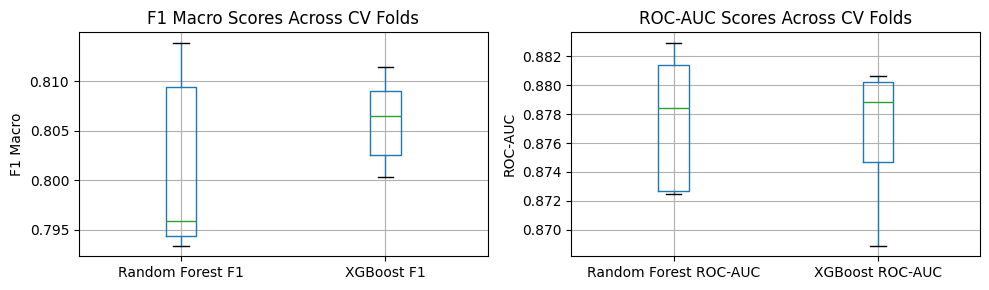

In [100]:
# Collect CV scores
cv_results = pd.DataFrame({
    'Random Forest F1': rf_f1_scores,
    'Random Forest ROC-AUC': rf_roc_scores,
    'XGBoost F1': xgb_f1_scores,
    'XGBoost ROC-AUC': xgb_roc_scores
})
# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# F1 Macro boxplot
cv_results[['Random Forest F1','XGBoost F1']].boxplot(ax=axes[0])
axes[0].set_title("F1 Macro Scores Across CV Folds")
axes[0].set_ylabel("F1 Macro")

# ROC-AUC boxplot
cv_results[['Random Forest ROC-AUC','XGBoost ROC-AUC']].boxplot(ax=axes[1])
axes[1].set_title("ROC-AUC Scores Across CV Folds")
axes[1].set_ylabel("ROC-AUC")

plt.tight_layout()
plt.show()

# 6. Hyperparameter Tuning (optimize models for best fraud detection performance)

In [101]:
results = []

# -------------------------------
# Baseline Random Forest
# -------------------------------
print("=== Baseline Random Forest ===")
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

rf_val_pred = rf_model.predict(X_val)
rf_val_prob = rf_model.predict_proba(X_val)[:, 1]

rf_auc = roc_auc_score(y_val, rf_val_prob)
rf_acc = accuracy_score(y_val, rf_val_pred)
rf_f1 = f1_score(y_val, rf_val_pred)

print(classification_report(y_val, rf_val_pred))
print("ROC-AUC:", rf_auc)

results.append({
    "Model": "RandomForest (Baseline)",
    "Accuracy": rf_acc,
    "F1-Score": rf_f1,
    "ROC-AUC": rf_auc
})

# -------------------------------
# Tuned Random Forest
# -------------------------------
print("\n=== Tuned Random Forest ===")
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=20,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf_random.fit(X_train, y_train)

rf_best = rf_random.best_estimator_
print("Best Params:", rf_random.best_params_)

rf_tuned_pred = rf_best.predict(X_val)
rf_tuned_prob = rf_best.predict_proba(X_val)[:, 1]

rf_tuned_auc = roc_auc_score(y_val, rf_tuned_prob)
rf_tuned_acc = accuracy_score(y_val, rf_tuned_pred)
rf_tuned_f1 = f1_score(y_val, rf_tuned_pred)

print(classification_report(y_val, rf_tuned_pred))
print("ROC-AUC:", rf_tuned_auc)

results.append({
    "Model": "RandomForest (Tuned)",
    "Accuracy": rf_tuned_acc,
    "F1-Score": rf_tuned_f1,
    "ROC-AUC": rf_tuned_auc
})

# -------------------------------
# Baseline XGBoost
# -------------------------------
print("\n=== Baseline XGBoost ===")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

xgb_val_pred = xgb_model.predict(X_val)
xgb_val_prob = xgb_model.predict_proba(X_val)[:, 1]

xgb_auc = roc_auc_score(y_val, xgb_val_prob)
xgb_acc = accuracy_score(y_val, xgb_val_pred)
xgb_f1 = f1_score(y_val, xgb_val_pred)

print(classification_report(y_val, xgb_val_pred))
print("ROC-AUC:", xgb_auc)

results.append({
    "Model": "XGBoost (Baseline)",
    "Accuracy": xgb_acc,
    "F1-Score": xgb_f1,
    "ROC-AUC": xgb_auc
})

# -------------------------------
# Tuned XGBoost
# -------------------------------
print("\n=== Tuned XGBoost ===")
xgb_param_grid = {
    'n_estimators': [200, 500, 800],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

xgb_random = RandomizedSearchCV(
    xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
xgb_random.fit(X_train, y_train)

xgb_best = xgb_random.best_estimator_
print("Best Params:", xgb_random.best_params_)

xgb_tuned_pred = xgb_best.predict(X_val)
xgb_tuned_prob = xgb_best.predict_proba(X_val)[:, 1]

xgb_tuned_auc = roc_auc_score(y_val, xgb_tuned_prob)
xgb_tuned_acc = accuracy_score(y_val, xgb_tuned_pred)
xgb_tuned_f1 = f1_score(y_val, xgb_tuned_pred)

print(classification_report(y_val, xgb_tuned_pred))
print("ROC-AUC:", xgb_tuned_auc)

results.append({
    "Model": "XGBoost (Tuned)",
    "Accuracy": xgb_tuned_acc,
    "F1-Score": xgb_tuned_f1,
    "ROC-AUC": xgb_tuned_auc
})

# -------------------------------
# Comparison Table
# -------------------------------
results_df = pd.DataFrame(results)
print("\n=== Model Comparison Table ===")
print(results_df)

=== Baseline Random Forest ===
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2263
           1       0.95      0.52      0.67       752

    accuracy                           0.87      3015
   macro avg       0.91      0.75      0.80      3015
weighted avg       0.88      0.87      0.86      3015

ROC-AUC: 0.8702382099641786

=== Tuned Random Forest ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2263
           1       0.97      0.51      0.66       752

    accuracy                           0.87      3015
   macro avg       0.91      0.75      0.79      3015
weighted avg       0.89      0.87      0.86      3015

ROC-AUC: 0.8784117298633898

=== Baseline XGBoost ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:36:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2263
           1       0.85      0.58      0.69       752

    accuracy                           0.87      3015
   macro avg       0.86      0.77      0.80      3015
weighted avg       0.87      0.87      0.86      3015

ROC-AUC: 0.8700293105555608

=== Tuned XGBoost ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:38:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.8}
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2263
           1       0.96      0.52      0.68       752

    accuracy                           0.88      3015
   macro avg       0.91      0.76      0.80      3015
weighted avg       0.89      0.88      0.86      3015

ROC-AUC: 0.8771636220043061

=== Model Comparison Table ===
                     Model  Accuracy  F1-Score   ROC-AUC
0  RandomForest (Baseline)  0.872968  0.669543  0.870238
1     RandomForest (Tuned)  0.872305  0.663755  0.878412
2       XGBoost (Baseline)  0.870315  0.690909  0.870029
3          XGBoost (Tuned)  0.876285  0.678725  0.877164


Observations:
* Random Forest tuning mostly improved discrimination power (ROC-AUC) but did not enhance threshold-based performance (accuracy, F1).

* XGBoost tuning improved overall accuracy and ROC-AUC, but at the expense of a slight F1-score drop.

# 7. Feature Importance Analysis
Compare feature importance from both models, using:
* Random Forest → Gini importance (mean decrease in impurity).
* XGBoost → Gain-based importance (how much each feature contributes to splits).

/tmp/ipython-input-3759693823.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3759693823.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


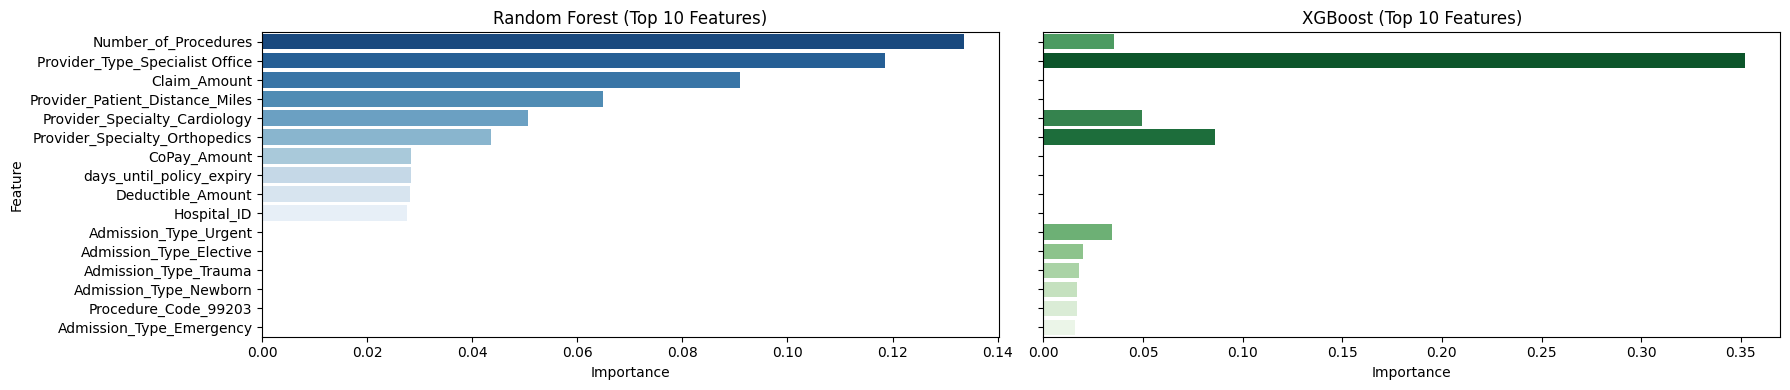

In [102]:
# -------------------------------
# Random Forest Feature Importance
# -------------------------------
rf_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf_best.feature_importances_
}).sort_values(by="Importance", ascending=False)

# -------------------------------
# XGBoost Feature Importance
# -------------------------------
xgb_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb_best.feature_importances_
}).sort_values(by="Importance", ascending=False)

# -------------------------------
# Plot Side-by-Side
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 4), sharey=True)

sns.barplot(
    data=rf_importances.head(10),
    x="Importance", y="Feature", ax=axes[0], palette="Blues_r"
)
axes[0].set_title("Random Forest (Top 10 Features)")

sns.barplot(
    data=xgb_importances.head(10),
    x="Importance", y="Feature", ax=axes[1], palette="Greens_r"
)
axes[1].set_title("XGBoost (Top 10 Features)")

plt.tight_layout()
plt.show()

Top features are consistent across models, and **the Top 3** features for both models are:
* `Provider_Type_Specialist Office`: is highly predictive suggests that where care is delivered is a stronger signal than patient demographic or other procedural details.

* `Provider_Specialty_Orthopedics`: is highly predictive suggests that by whom care is delivered is a stronger signal than patient demographic. This could mean outcomes are provider-driven rather than patient-driven.

* `Number_of_Procedures`: More procedures often correlate with more complex cases. It's highly predictive suggests that case complexity is a major driver of the prediction

The care setting (specialist office, cardiology) and case complexity (number of procedures) are the primary determinants in your prediction task.

100%|===================| 6027/6030 [05:29<00:00]       

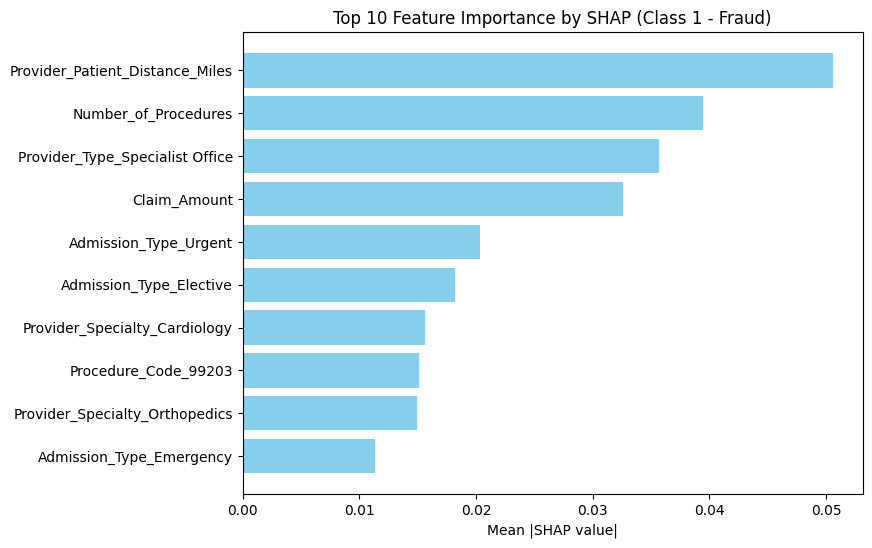

In [103]:
# Use the full X_val used for model
explainer = shap.Explainer(rf_best, X_val)
shap_values = explainer(X_val)

# Convert to numpy array for class 1 (fraud)
shap_class1 = shap_values.values[:, :, 1]  # samples x features

# Compute mean absolute SHAP per feature
mean_abs_shap = np.abs(shap_class1).mean(axis=0)

feature_importance = pd.DataFrame({
    'feature': X_val.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False)

# Plot top 10 features
plt.figure(figsize=(8,6))
plt.barh(feature_importance['feature'][:10][::-1],
         feature_importance['mean_abs_shap'][:10][::-1],
         color='skyblue')
plt.xlabel('Mean |SHAP value|')
plt.title('Top 10 Feature Importance by SHAP (Class 1 - Fraud)')
plt.show()

Conclusion on SHAP:
* Being treated in a Specialist Office adds +5%.
* Each additional procedure increases probability by +2% up to a certain threshold.

#8. Improve ARIMA model:
As result shown above, ARIMA is only useful for time-series numeric prediction (Claim_Amount over time) and does not directly predict fraud. I decide to aggregate `Claim_Amount` for ARIMA model.

/tmp/ipython-input-4102130564.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_claim = df_ts['Claim_Amount'].resample('M').mean()


ARIMA Performance:
MSE: 1150584406.36
RMSE: 33920.27
MAE: 28857.34
MAPE: 2.34%


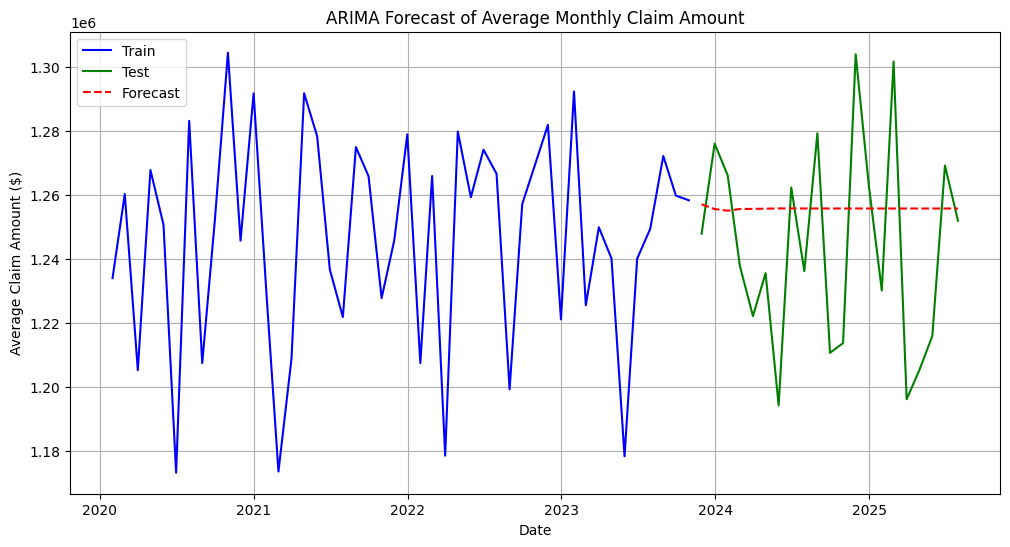

In [105]:
# -------------------------------
# Step 1: Aggregate Claim_Amount by month
# -------------------------------

# Set Claim_Date as index
df_ts = df_encoded.set_index('Claim_Date')

# Resample monthly and take average Claim_Amount
monthly_claim = df_ts['Claim_Amount'].resample('M').mean()

# Split into train/test (70%-30%)
train_size = int(len(monthly_claim) * 0.7)
train, test = monthly_claim[:train_size], monthly_claim[train_size:]

# -------------------------------
# Step 2: Fit ARIMA model
# -------------------------------
# You can tune p,d,q, here example: (5,1,0)
arima_model = sm.tsa.ARIMA(train, order=(5,1,0))
arima_result = arima_model.fit()

# Forecast
forecast = arima_result.forecast(steps=len(test))

# -------------------------------
# Step 3: Evaluate performance
# -------------------------------
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("ARIMA Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# -------------------------------
# Step 4: Plot forecast vs actual
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Average Claim Amount ($)')
plt.title('ARIMA Forecast of Average Monthly Claim Amount')
plt.legend()
plt.grid(True)
plt.show()

Conclusion:
* A MAPE of 2.34% shows that the accuracy is strong as the ARIMA forecasts are, on average, within ~2–3% of the actual monthly mean claim amount.
* Small data size: This data ranges from 2022 Aug to 2025 Jun, since we aggregate monthly Claim_Amount, it only contains a 33-length time series. ARIMA models need at least ~50–100 time points to robustly learn structure (especially seasonality). With only 33, the model can still be fit, but it’s constrained in what it can learn.